# Setup

In [1]:
DATA_VERSION = "2025-07-14"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"


LANGUAGES = {
    "de",
    # "fr",
    # "it",
}
TOPIC_LABEL_SOURCES = {
    # "openparldata",
    # "organisation_rule",
    "manual",
}

# FROM_YEAR = 2010
FROM_YEAR = 2000

MIN_CONSULTATIONS_IN_CLASS = 40

_approximate_topic_f1_scores = {
    "administration": 0.563,
    "agriculture": 0.833,
    "communications": 0.787,
    "defense": 0.712,
    "economics": 0.541,
    "education": 0.782,
    "energy": 0.857,
    "environment": 0.702,
    "finance": 0.683,
    "foreign_policy": 0.638,
    "health": 0.83,
    "housing": 0.69,
    "insurance": 0.832,
    "it": 0.606,
    "law": 0.53,
    "migration": 0.909,
    "public_finance": 0.701,
    "science": 0.543,
    "security": 0.555,
    "social": 0.498,
    "spatial_planning": 0.677,
    "transportation": 0.842,
}

IGNORE_TOPICS = {
    # t
    # for t, f1 in _approximate_topic_f1_scores.items()
    # if f1 < 0.8
}

DOC_TYPES = {
    "DRAFT",
    # None,  # Many openparldata documents don't have a known type
    # "VARIOUS_TEXT",
    # "LETTER",
    # "RECIPIENT_LIST",  # proven to not be useful
    # "REPORT",
    # "FINAL_REPORT",
    # "OPINION",
    # "SYNOPTIC_TABLE",  # possibly not useful?
    # "SURVEY",
    # "RESPONSE_FORM",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 271

In [2]:
%load_ext autoreload
%autoreload 2

import pathlib
import re
import sys

import dotenv
import matplotlib.pyplot as plt
import mlflow
import nltk
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
# nltk.download("stopwords")

In [ ]:
import research.consultation_topics.archive.preprocessing
from research.lib import data_access, plotting, stratified_group_split, utils

In [5]:
dotenv.load_dotenv()
utils.set_up_logging_and_mlflow("VM_classical_topic_classifier")

mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("topic_label_sources", sorted(TOPIC_LABEL_SOURCES))
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("min_consultations_in_class", MIN_CONSULTATIONS_IN_CLASS)
mlflow.log_param("ignore_topics", sorted(IGNORE_TOPICS))
mlflow.log_param("doc_types", sorted(map(str, DOC_TYPES)))
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

INFO research.lib.utils: MLflow tracking to https://mlflow.ml1.demokratis.ch/
INFO research.lib.utils: Starting run = receptive-shad-667


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/07/16 08:55:42 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.6.1, but the installed version is 1.7.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-07-14.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_languages=LANGUAGES,
    only_doc_types=DOC_TYPES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_docs = df_docs[df_docs["consultation_topics_label_source"].isin(TOPIC_LABEL_SOURCES)]
df_docs

,document_uuid,consultation_identifier,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_name,political_body,latest_stored_file_uuid,document_source,consultation_topics_label_source,document_type_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1CAJoURQMxKeqCdQ4jLniS,7bt3hz2w,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,Bundesamt für Zoll und Grenzsicherheit,ch,1CM3wffQLMxGCHhjJ6PKmR,fedlex,manual,fedlex,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
21,1CAJoURregQSBjKq3Pp2mL,a49pncfq,2021-12-03,2022-03-18,Änderung der Verordnung über Fernmeldedienste ...,In Vollzug von Artikel 48a FMG über die Sicher...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/a49pncfq,"[communications, it, security]","[{'created_at': 2025-01-27 11:30:14, 'name': '...",...,Bundesamt für Kommunikation,ch,1CM3wg6vz2uQ3oZqEQcf7s,fedlex,manual,fedlex,[Signature] \n[QR Code] \n \n1 \nVerordnung \n...,2024/2/22/1CM3wg6vjrx6u67JD8PayD.pdf,application/pdf,8fb68017e53055498c277ed8afe60d56ee2935aa
42,1CAJoUSHBj4qdYJPe3PFcd,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgUgRrjEFontegfgyd,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/43/1CM3wgUcDxsq2yKqdZsaGe.pdf,application/pdf,98a60f2d0b0b0ce18b5ce82a1e9df248c3629bb9
51,1CAJoUSHBj4qdYJPedbRja,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgwv3CkfxghjShq2NP,fedlex,manual,fedlex,1 \nRaumplanungsverordnung \n \nVernehmlassung...,2024/3/52/1CM3wgwuYYGtzYePP6ETCu.pdf,application/pdf,0ec7371d74bfec45d6b022706fe669bee7005ded
54,1CAJoUSHBj4qdYJPepDs22,tcspwfam,2021-10-11,2022-01-25,"Teilrevisionen der Raumplanungsverordnung, der...","Das Eidgenössische Departement für Umwelt, Ver...",https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/tcspwfam,"[energy, spatial_planning]","[{'created_at': 2025-02-11 13:16:43, 'name': '...",...,Bundesamt für Energie,ch,1CM3wgyzoKLLbozGmFEg75,fedlex,manual,fedlex,2021-… \n \nVerordnung \n \n \n \nVernehmlass...,2024/3/55/1CM3wgyzJL2fSpmyQyW3Uj.pdf,application/pdf,fc01f855d3a18f17ee7b3b9add690ded4d9d2764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53959,1CQXzKRuXrxxk6ymwxFVdW,end6g7hp,2025-06-25,2025-10-15,Änderung des Wasserrechtsgesetzes (Umsetzung M...,Gegenstand der vorliegenden Vernehmlassungsvor...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/end6g7hp,"[energy, environment]","[{'created_at': 2025-05-07 14:07:37, 'name': '...",...,Bundesamt für Energie,ch,1CQdqZXWjjq9rvKbTVwpfU,fedlex,manual,fedlex,«$$e-seal»\n«$$QrCode»\n2024-...\n«%ASFF_YYYY_...,2025/5113/55961/1CQdqZXWVqhRV7H1wXgf1V.pdf,application/pdf,0df91a8ba027b8a2a481771fd88328e066dcf57a
53974,1CQXzKTmtroZUKrXVYMHQq,jh9ctnan,2025-06-25,2025-10-16,Verordnungspaket Umwelt Frühling 2026,"Anpassu

## Create the input dataframe

In [9]:
def documents_to_consultation(x: pd.DataFrame) -> pd.Series:
    def get(key: str) -> str:
        return x[key].iloc[0]

    return pd.Series(
        {
            "text": "\n\n".join(
                [
                    get("consultation_title"),
                    get("consultation_description"),
                    get("organisation_name"),
                    *x["document_content_plain"].tolist(),
                ]
            ),
            "consultation_topics": get("consultation_topics"),
            "consultation_topics_label_source": get("consultation_topics_label_source"),
        }
    )


df_input = (
    df_docs[df_docs["document_content_plain"].str.strip() != ""]
    .groupby("consultation_identifier")
    .apply(documents_to_consultation)
    .reset_index()
)
df_input

/var/folders/zq/k8fwbncx1vg2swbktbl1t4z00000gp/T/ipykernel_9094/1003818624.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(documents_to_consultation)


,consultation_identifier,text,consultation_topics,consultation_topics_label_source
0,2259wqvq,Revision der Asylverordnung 2 über Finanzierun...,"[migration, public_finance]",manual
1,22mkgk7j,Änderung der Verordnung über die CO2-Abgabe (C...,"[energy, environment, housing, public_finance]",manual
2,22rhfj95,Änderung der Verordnung über die Bekämpfung de...,"[finance, foreign_policy, security]",manual
3,254aynz4,Änderung des Elektrizitätsgesetzes (Beschleuni...,[energy],manual
4,26j4aved,Anhörung zur Änderung der Energieverordnung (E...,"[energy, environment, public_finance]",manual
...,...,...,...,...
1044,zygt9epc,Teilrevision des Strahlenschutzgesetzes (StSG)...,"[energy, health, security]",manual
1045,zyuux9us,Fischereigesetz\n\nDer Regierungsrat des Kanto...,"[agriculture, environment, social]",manual
1046,zzby35xf,08.520 Parlamentarische Initiative. Abschaffun...,"[insurance, sports, transportation]",manual
1047,zzvn2q9r,Bundesgesetz über die Besteuerung des mobilen ...,"[economics, foreign_policy, public_finance]",manual


In [ ]:
df_input, topic_columns = research.consultation_topics.archive.preprocessing.encode_topics(df_input)
df_input

,consultation_identifier,text,consultation_topics,consultation_topics_label_source,topic_administration,topic_agriculture,topic_communications,topic_culture,topic_defense,topic_economics,...,topic_media,topic_migration,topic_political_system,topic_public_finance,topic_science,topic_security,topic_social,topic_spatial_planning,topic_sports,topic_transportation
0,2259wqvq,Revision der Asylverordnung 2 über Finanzierun...,"[migration, public_finance]",manual,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,22mkgk7j,Änderung der Verordnung über die CO2-Abgabe (C...,"[energy, environment, housing, public_finance]",manual,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,22rhfj95,Änderung der Verordnung über die Bekämpfung de...,"[finance, foreign_policy, security]",manual,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,254aynz4,Änderung des Elektrizitätsgesetzes (Beschleuni...,[energy],manual,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26j4aved,Anhörung zur Änderung der Energieverordnung (E...,"[energy, environment, public_finance]",manual,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,zygt9epc,Teilrevision des Strahlenschutzgesetzes (StSG)...,"[energy, health, security]",manual,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1045,zyuux9us,Fischereigesetz\n\nDer Regierungsrat des Kanto...,"[agriculture, environment, social]",manual,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1046,zzby35xf,08.520 Parlamentarische Initiative. Abschaffun...,"[insurance, sports, transportation]",manual,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1047,zzvn2q9r,Bundesgesetz über die Besteuerung des mobilen ...,"[economics, foreign_policy, public_finance]",manual,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## Drop underrepresented topics

In [ ]:
df_input, topic_columns = research.consultation_topics.archive.preprocessing.drop_underrepresented_topics(
    df_input,
    topic_columns,
    MIN_CONSULTATIONS_IN_CLASS,
    always_drop_topics=IGNORE_TOPICS,
)

Dropping these underrepresented classes:
topic_culture             38
topic_media               11
topic_political_system    37
topic_sports              28
dtype: int64
Dropping these documents without any label: 2


In [12]:
print("Original number of documents:", df_docs.shape[0])
print("df_input size (consultations):", df_input.shape[0])

Original number of documents: 1615
df_input size (consultations): 1047


## Split

In [13]:
splitter = stratified_group_split.MultilabelStratifiedGroupShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(
    splitter.split(df_input, df_input[topic_columns], groups=df_input["consultation_identifier"])
)

In [14]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

assert not set(df_input_train["consultation_identifier"]) & set(df_input_test["consultation_identifier"]), (
    "No leakage between train and test sets"
)

mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (940, 26)
Test: (107, 26)


# Data exploration

In [15]:
df_input_train.groupby("consultation_identifier").agg({"consultation_topics": "first"}).explode(
    "consultation_topics"
).value_counts()

consultation_topics
economics              221
public_finance         205
security               180
health                 155
administration         149
foreign_policy         130
it                     124
social                 110
environment            108
finance                103
transportation          95
insurance               94
energy                  88
agriculture             86
migration               79
education               71
law                     71
spatial_planning        67
housing                 52
communications          49
defense                 40
science                 40
political_system        34
culture                 31
sports                  20
media                    8
Name: count, dtype: int64

# Classification

In [16]:
def create_matrices(df: pd.DataFrame) -> tuple[pd.Series, pd.DataFrame]:
    x = df["text"]
    y = df[topic_columns]
    return x, y


def create_classifier(random_state: int) -> Pipeline:
    stop_words = [
        *nltk.corpus.stopwords.words("german"),
        "asff_yyyy_id",
        "vernehmlassung",
    ]

    def preprocess(text: str) -> str:
        text = re.sub(r"\bSR \d+\b", "", text)
        text = text.lower()
        return text

    return make_pipeline(
        TfidfVectorizer(max_features=50_000, ngram_range=(1, 2), stop_words=stop_words, preprocessor=preprocess),
        OneVsRestClassifier(
            LogisticRegression(solver="liblinear", class_weight="balanced"),
            n_jobs=-1,
        ),
    )


X_train, y_train = create_matrices(df_input_train)
X_test, y_test = create_matrices(df_input_test)

groups_train = df_input_train["consultation_identifier"]
groups_test = df_input_test["consultation_identifier"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (940,) (940, 22)
Test (107,) (107, 22)


## CV

In [17]:
classifier_cv = create_classifier(RANDOM_STATE)
classifier_cv

,steps,"[('tfidfvectorizer', ...), ('onevsrestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cre...t 0x30d8565c0>
,tokenizer,None


In [18]:
cv = stratified_group_split.MultilabelStratifiedGroupKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)


# def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
#     """If PCA is used in the pipeline, include its explained variance in scores."""
#     try:
#         pca = pipeline.named_steps["pca"]
#     except KeyError:
#         return np.nan
#     explained_variance = np.sum(pca.explained_variance_ratio_)
#     return explained_variance


args = {
    "estimator": classifier_cv,
    "X": X_train,
    "y": y_train,
    "groups": groups_train,
    "cv": cv,
    "verbose": 2,
    "n_jobs": -1,
}

print("cross_validate...")
cv_scores = sklearn.model_selection.cross_validate(
    **args,
    scoring={
        "precision": "precision_samples",
        "recall": "recall_samples",
        "f1": "f1_samples",
        # "pca_explained_variance": explained_variance_scorer,
    },
)
display(cv_scores)

print("\ncross_val_predict...")
y_cv_predicted = sklearn.model_selection.cross_val_predict(**args)

cross_validate...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type =

[CV] END .................................................... total time=   6.3s
[CV] END .................................................... total time=   6.4s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=   6.5s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/utils/_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[CV] END .................................................... total time=   6.7s
[CV] END .................................................... total time=   7.1s


/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


{'fit_time': array([5.17255402, 6.64655709, 5.73543715, 5.57235098, 6.10612607]),
 'score_time': array([1.08862185, 0.43545699, 0.74400711, 0.82555795, 0.63766098]),
 'test_precision': array([0.65837838, 0.66036036, 0.67491228, 0.67780656, 0.64688057]),
 'test_recall': array([0.56261261, 0.5481982 , 0.57105263, 0.59240069, 0.57442068]),
 'test_f1': array([0.56765766, 0.56971686, 0.58320802, 0.59312855, 0.57776929])}


cross_val_predict...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


In [19]:
utils.log_metrics(**{k.replace("test_", "cv_"): np.mean(v) for k, v in cv_scores.items() if k.startswith("test_")})

{'cv_f1': 0.5783, 'cv_precision': 0.6637, 'cv_recall': 0.5697}


In [20]:
utils.log_classification_report("cv_consultations", y_train, y_cv_predicted, target_names=topic_columns)

cv_consultations_classification_report.txt

                        precision    recall  f1-score   support

  topic_administration       0.47      0.46      0.46       149
     topic_agriculture       0.83      0.67      0.74        86
  topic_communications       0.96      0.47      0.63        49
         topic_defense       0.90      0.45      0.60        40
       topic_economics       0.58      0.41      0.48       221
       topic_education       0.80      0.58      0.67        71
          topic_energy       0.86      0.65      0.74        88
     topic_environment       0.70      0.57      0.63       108
         topic_finance       0.71      0.43      0.53       103
  topic_foreign_policy       0.72      0.59      0.65       130
          topic_health       0.93      0.63      0.75       155
         topic_housing       0.89      0.31      0.46        52
       topic_insurance       0.96      0.78      0.86        94
              topic_it       0.64      0.55      0.59      

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


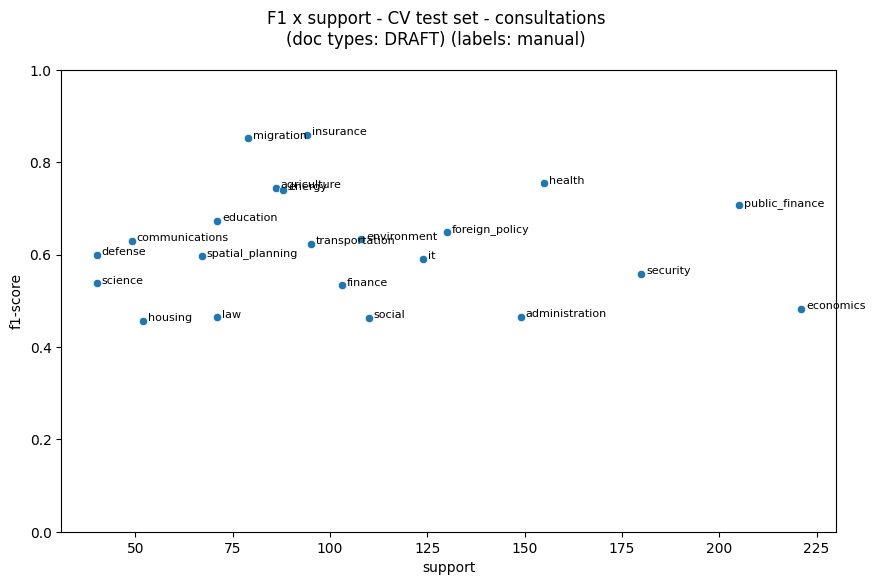

<Figure size 640x480 with 0 Axes>

In [21]:
fig = plotting.plot_score_against_support(
    y_train.values,
    y_cv_predicted,
    target_names=topic_columns,
)
document_types = "+".join(sorted(t if t else "unknown" for t in DOC_TYPES))
label_sources = "+".join(sorted(df_input["consultation_topics_label_source"].unique()))
fig.suptitle(
    "\n".join(
        [
            "F1 x support - CV test set - consultations",
            f"(doc types: {document_types}) (labels: {label_sources})",
        ]
    )
)
plt.tight_layout()
mlflow.log_figure(fig, "cv_consultations_score_against_support.png")
fig

## Training

2025/07/16 08:56:07 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
2025/07/16 08:56:22 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: multilabel-indicator is not supported
2025/07/16 08:56:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


''

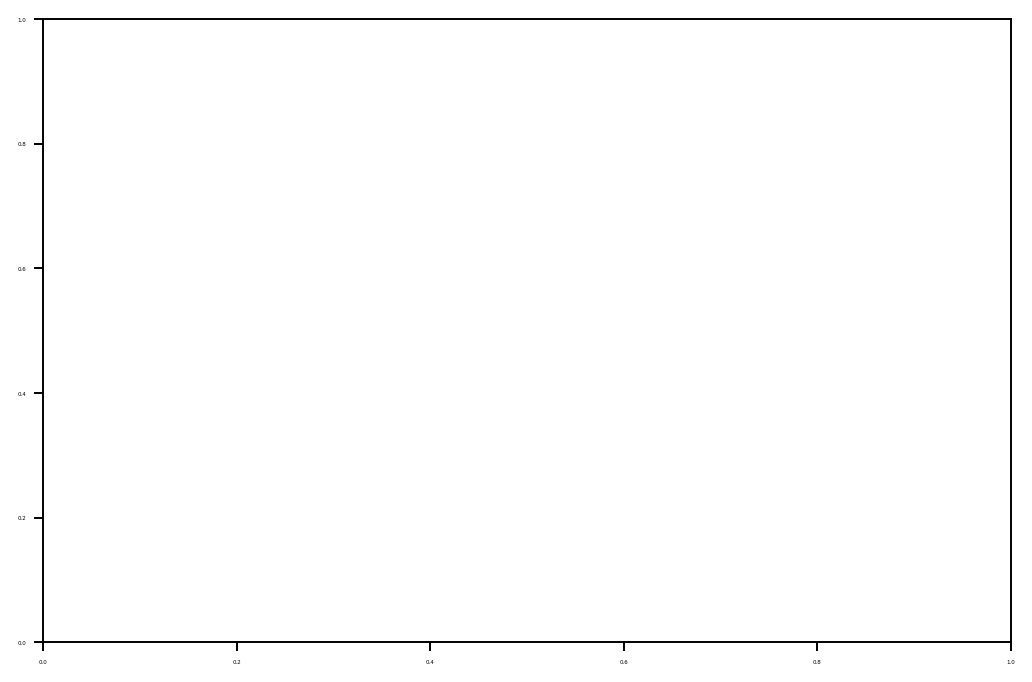

In [22]:
classifier_test = create_classifier(RANDOM_STATE)
classifier_test.fit(X_train, y_train)
;

## Evaluation on the test set

In [23]:
y_test_predicted = classifier_test.predict(X_test)

2025/07/16 08:56:30 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


In [24]:
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
    y_test,
    y_test_predicted,
    average="samples",
    zero_division=np.nan,
)
scores_consultations = {"test_precision": precision, "test_recall": recall, "test_f1": f1}
utils.log_metrics(**scores_consultations)

{'test_f1': 0.6045, 'test_precision': 0.7228, 'test_recall': 0.6067}


test_consultations_classification_report.txt

                        precision    recall  f1-score   support

  topic_administration       0.60      0.35      0.44        17
     topic_agriculture       0.75      0.60      0.67        10
  topic_communications       1.00      0.67      0.80         6
         topic_defense       1.00      0.20      0.33         5
       topic_economics       0.60      0.48      0.53        25
       topic_education       0.80      1.00      0.89         8
          topic_energy       0.89      0.80      0.84        10
     topic_environment       0.83      0.83      0.83        12
         topic_finance       0.88      0.64      0.74        11
  topic_foreign_policy       0.58      0.47      0.52        15
          topic_health       0.91      0.43      0.59        23
         topic_housing       1.00      0.83      0.91         6
       topic_insurance       0.88      0.70      0.78        10
              topic_it       0.60      0.64      0.62    

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


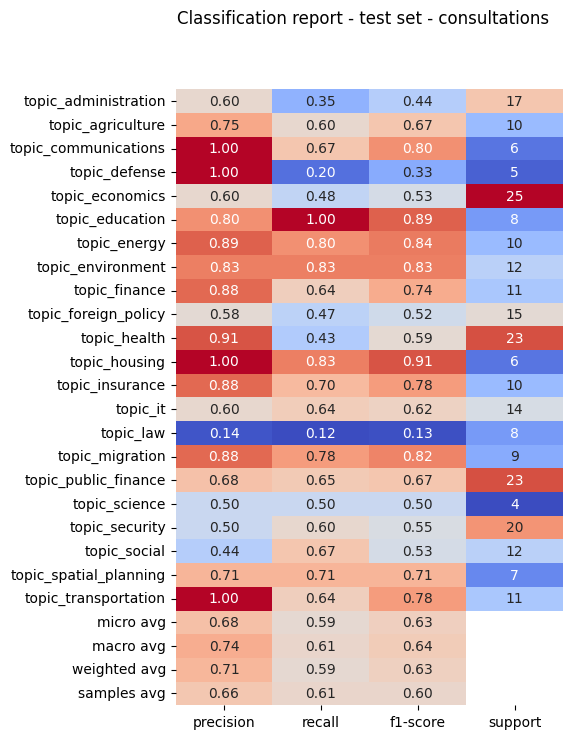

<Figure size 640x480 with 0 Axes>

In [25]:
utils.log_classification_report(
    "test_consultations",
    y_test,
    y_test_predicted,
    target_names=topic_columns,
)

fig = plotting.plot_classification_report_heatmap(
    y_test.values,
    y_test_predicted,
    target_names=topic_columns,
)
fig.suptitle("Classification report - test set - consultations")
mlflow.log_figure(fig, "test_consultations_classification_report.png")
plt.tight_layout()
display(fig)

## Feature importance

In [26]:
from IPython.core.display import HTML

# After fitting:
#   tfidf: your fitted TfidfVectorizer
#   clf: your fitted OneVsRestClassifier
#   mlb: the MultiLabelBinarizer you used
tfidf = classifier_test.named_steps["tfidfvectorizer"]
clf = classifier_test.named_steps["onevsrestclassifier"]


# 1. Grab the n-gram feature names
feature_names = np.array(tfidf.get_feature_names_out())

# 2. For each class, sort its coefficients
topn = 20  # how many top features you want

rows = []
for idx, class_label in enumerate(topic_columns):
    # coef_ shape is (n_classes, n_features) but for OneVsRestClassifier
    # each estimator.coef_ is shape (1, n_features)
    coef = clf.estimators_[idx].coef_.flatten()

    # top positive features
    top_pos_idx = np.argsort(coef)[-topn:][::-1]
    top_pos = feature_names[top_pos_idx]
    top_pos_weights = coef[top_pos_idx]

    # top negative features (most anti-predictive)
    top_neg_idx = np.argsort(coef)[:topn]
    top_neg = feature_names[top_neg_idx]
    top_neg_weights = coef[top_neg_idx]

    # collect into a DataFrame-friendly structure
    for term, weight in zip(top_pos, top_pos_weights, strict=False):
        rows.append((class_label, "pos", term, weight))
    for term, weight in zip(top_neg, top_neg_weights, strict=False):
        rows.append((class_label, "neg", term, weight))

# 3. Build a DataFrame for nicer display
df_imp = pd.DataFrame(rows, columns=["class", "sign", "ngram", "weight"])

# Now you can, for example, show the top positive n-grams for one class:
for cls in topic_columns:
    display(HTML(f"<h3>{cls}</h3>"))
    print(
        df_imp.loc[(df_imp["class"] == cls) & (df_imp["sign"] == "pos"), ["ngram", "weight"]]
        .sort_values("weight", ascending=False)
        .head(topn)
    )

# # Or pivot to see both pos/neg in one table:
# pivot = df_imp.pivot_table(index="ngram", columns=["class", "sign"], values="weight")
# print(pivot.head(50))

                 ngram    weight
0                  abs  1.317191
1          politischen  1.302159
2             gebühren  1.220218
3   politischen rechte  1.168303
4           government  1.082044
5              kantons  1.011531
6          stimmabgabe  1.006719
7        regierungsrat  0.998504
8                   id  0.965376
9                finma  0.946783
10                 neu  0.934048
11                 ehb  0.928234
12           amtlichen  0.921991
13          aufgehoben  0.917143
14        staatsgrenze  0.876967
15          vermessung  0.874856
16                lkch  0.870281
17         stimmzettel  0.864361
18              bundes  0.856943
19  verrechnungssteuer  0.854816


                       ngram    weight
40            landwirtschaft  3.167460
41                     tiere  2.682944
42       landwirtschaftliche  1.626804
43                       blw  1.567412
44      landwirtschaftlichen  1.546225
45                    tieren  1.453518
46                       blv  1.437730
47                jagdgesetz  1.384348
48                massnahmen  1.362515
49                      jagd  1.228499
50     landwirtschaftsgesetz  1.206081
51                      wald  1.201720
52                organismen  1.193082
53              gentechnisch  1.180909
54                    anhang  1.152774
55     pflanzenschutzmitteln  1.133730
56               erzeugnisse  1.100013
57    tiergesundheitsdienste  1.089780
58                   einfuhr  1.052561
59  bundesamt landwirtschaft  1.035125


                         ngram    weight
80                       bakom  2.871941
81                        post  2.662042
82                       radio  2.621696
83               anbieterinnen  1.893687
84               kommunikation  1.492287
85             stromversorgung  1.472950
86  mobilfunkkonzessionärinnen  1.368751
87            fernmeldedienste  1.365542
88        raumfahrtaktivitäten  1.333730
89                    symbolen  1.315999
90                    reklamen  1.313677
91                   fernsehen  1.302696
92             prozesshandlung  1.295083
93                         srg  1.280259
94             radio fernsehen  1.251232
95            abstimmungsspots  1.246554
96                      zugang  1.195072
97     bundesamt kommunikation  1.169871
98                 alarmierung  1.153945
99             grundversorgung  1.136921


                                ngram    weight
120                             armee  3.351621
121                               ndb  2.408371
122                     militärischen  1.939301
123           wehrpflichtersatzabgabe  1.764309
124                       zivilschutz  1.751850
125                              jstg  1.675850
126                  landesversorgung  1.621693
127                    kriegsmaterial  1.608891
128                       zivildienst  1.583887
129                          swissgas  1.511880
130                bevölkerungsschutz  1.499234
131                               bsa  1.450185
132                      ersatzabgabe  1.392151
133                       kulturgüter  1.387620
134                               vbs  1.339203
135                      militärische  1.336526
136                              babs  1.323831
137  wirtschaftliche landesversorgung  1.265329
138            sicherheitspolitischen  1.261855
139                         luftraums  1

                            ngram    weight
160                  arbeitnehmer  1.297767
161                   unternehmen  1.294178
162              erwerbstätigkeit  1.038557
163                         mwstg  1.026197
164                 arbeitsgesetz  1.019522
165             arbeitnehmerinnen  0.867634
166                   arbeitgeber  0.800158
167                 berufsbildung  0.790342
168              ergänzungssteuer  0.775797
169                 weiterbildung  0.769097
170       überbrückungsleistungen  0.733649
171                    wirtschaft  0.706565
172                     tourismus  0.703479
173            regulierungskosten  0.683875
174                           ehb  0.663231
175      arbeitslosenversicherung  0.647066
176           beherbergungsabgabe  0.641295
177               fachhochschulen  0.623547
178  staatssekretariat wirtschaft  0.616935
179    bereitschaftsentschädigung  0.611331


                     ngram    weight
200          berufsbildung  2.352371
201             ausbildung  2.316056
202                    eth  2.059188
203          weiterbildung  1.904461
204                   sbfi  1.871958
205                bildung  1.771830
206                schüler  1.514114
207           schülerinnen  1.410811
208            hochschulen  1.407125
209            beruflichen  1.396474
210                    ehb  1.382415
211           grundbildung  1.349408
212           lehrpersonen  1.344638
213  berufsqualifikationen  1.307553
214            anerkennung  1.270505
215                höheren  1.270414
216    ausbildungsbeiträge  1.258045
217                movetia  1.250660
218                 pflege  1.239874
219        fachhochschulen  1.221122


                    ngram    weight
240               energie  3.492970
241                   bfe  2.227807
242               anlagen  2.094946
243                   co2  1.753058
244       stromversorgung  1.468200
245                 elcom  1.391735
246              energien  1.294670
247               prozent  1.272397
248              planungs  1.231783
249          stilllegungs  1.160950
250          elektrischer  1.157961
251  elektrischer energie  1.146721
252            massnahmen  1.113269
253     bundesamt energie  1.106145
254          elektrizität  1.084528
255          jodtabletten  1.078958
256                 klima  1.057542
257        endverbraucher  1.034623
258                umwelt  1.011280
259                 strom  1.006982


               ngram    weight
280             bafu  1.997406
281              co2  1.749375
282          anlagen  1.475188
283           umwelt  1.443740
284       massnahmen  1.375222
285      abgeltungen  1.300403
286         gewässer  1.258220
287  fachbewilligung  1.246999
288          energie  1.226110
289            natur  1.184211
290         pflanzen  1.163487
291       jagdgesetz  1.156581
292             jagd  1.103008
293     meteoschweiz  1.082073
294             wald  1.080858
295              gwp  1.059757
296       organismen  1.059231
297         erdbeben  1.024891
298          abfälle  0.991994
299      geologische  0.972350


                        ngram    weight
320                     finma  3.152048
321                      bank  1.843162
322        verrechnungssteuer  1.295567
323                    banken  1.258187
324                   prozent  1.244590
325               zuwendungen  1.233641
326                  einlagen  1.050049
327       vorsorgeeinrichtung  1.001547
328              mietbeiträge  1.000550
329              nationalbank  0.965706
330                 vermieter  0.939673
331                       qif  0.924310
332                       eth  0.914395
333  versicherungsunternehmen  0.906068
334                     bankg  0.902153
335                       dlt  0.899571
336                  mietzins  0.865180
337                       bgs  0.852801
338            staatsbeiträge  0.847854
339                     gespa  0.846815


               ngram    weight
360               eu  2.339574
361          schweiz  2.020853
362  internationalen  1.815531
363         schengen  1.500387
364            finma  1.499281
365    übereinkommen  1.429010
366              ndb  1.393819
367   internationale  1.320791
368     europäischen  1.156000
369    informationen  1.118026
370          staaten  1.117229
371    ausländischen  1.113614
372          betteln  1.078788
373             estv  1.050396
374              the  1.048267
375  vertragsstaaten  0.999287
376          ausland  0.987255
377   übereinkommens  0.964775
378        schweizer  0.928575
379            hamas  0.918064


                     ngram    weight
400    krankenversicherung  2.343787
401                    bag  1.911249
402                    kvg  1.805503
403            versicherer  1.782157
404             gesundheit  1.570075
405                  tiere  1.500186
406                    blv  1.381894
407                 pflege  1.329428
408               menschen  1.157787
409               covid 19  1.129758
410                  covid  1.111475
411          krankenpflege  1.079849
412     unfallversicherung  1.072302
413             verordnung  1.045359
414       patientendossier  1.032866
415           versicherten  1.030943
416          medizinischen  1.018291
417          behinderungen  0.988702
418  invalidenversicherung  0.983623
419           lebensmittel  0.976055


                   ngram    weight
440                  co2  2.053230
441            wohnungen  1.926510
442              gebäude  1.820180
443  zweitliegenschaften  1.692573
444            mietzinse  1.659580
445         grundstücken  1.533419
446         liegenschaft  1.532079
447                 miet  1.512664
448             erdbeben  1.468169
449           grundstück  1.455065
450                  gwr  1.429469
451                  bsa  1.397482
452       zweitwohnungen  1.388521
453              wohnung  1.381027
454         mietbeiträge  1.279208
455                miete  1.279075
456            vermieter  1.259122
457       liegenschaften  1.219838
458          postfinance  1.195027
459  stockwerkeigentümer  1.192778


                        ngram    weight
480       krankenversicherung  3.207076
481              versicherten  2.701498
482                       kvg  2.357856
483                       ahv  2.084281
484               versicherer  2.018546
485               versicherte  1.897393
486  versicherungsunternehmen  1.771774
487                    alters  1.670742
488     invalidenversicherung  1.612520
489        unfallversicherung  1.458789
490        versicherte person  1.349404
491                leistungen  1.308437
492                       ifi  1.294464
493              versicherung  1.239254
494                  erdbeben  1.238333
495                   prämien  1.236893
496                       bsv  1.193296
497                    absatz  1.166916
498                   artikel  1.163318
499                       vag  1.138821


                  ngram    weight
520               daten  5.101373
521       elektronische  1.975900
522      elektronischen  1.645064
523          government  1.410379
524               bakom  1.342957
525  informationssystem  1.320958
526       personendaten  1.246952
527    patientendossier  1.139129
528       informationen  1.078595
529              zugang  1.056921
530           plattform  1.001510
531                 art  0.976785
532          telearbeit  0.973279
533               organ  0.953045
534       anbieterinnen  0.950787
535         stimmabgabe  0.880010
536                 gir  0.847574
537      finanzinstitut  0.834407
538                 vis  0.822953
539                 dlt  0.790750


                    ngram    weight
560                person  1.895628
561               gericht  1.859966
562                   art  1.481847
563                  stgb  1.410321
564                   sem  1.405878
565                   ige  1.250418
566               richter  1.167698
567              symbolen  1.092714
568                justiz  1.078931
569             verfahren  1.075441
570            verfassung  1.049747
571                   zgb  1.020567
572       prozesshandlung  1.017098
573  schaffhauser polizei  1.016675
574            messmittel  1.014809
575          abs geändert  0.999000
576     kantonsverfassung  0.989094
577                  jstg  0.953490
578                   ton  0.930926
579          schaffhauser  0.926615


                        ngram    weight
600                 ausländer  2.756088
601                       sem  2.271969
602            ausländerinnen  2.132104
603                     asylg  2.026743
604                  schengen  1.956302
605                       the  1.690843
606                       aig  1.686444
607                aufenthalt  1.562584
608  ausländerinnen ausländer  1.550796
609                       bfm  1.541424
610                        eu  1.505067
611                  personen  1.482995
612    aufenthaltsbewilligung  1.422799
613              europäischen  1.379353
614                      bazg  1.273587
615                    erwerb  1.248357
616            zollverwaltung  1.244923
617                      asyl  1.233133
618                 vorläufig  1.223187
619                       vis  1.210442


                    ngram    weight
640               franken  1.951924
641          finanzhilfen  1.936089
642              beiträge  1.524901
643         regierungsrat  1.455224
644              darlehen  1.441772
645                steuer  1.146155
646    verrechnungssteuer  1.113508
647                  estv  1.105884
648                    fr  1.061834
649                   000  1.021248
650      steuerpflichtige  1.019042
651             förderung  1.017993
652                 mwstg  1.009421
653                kosten  0.991247
654                abgabe  0.929923
655      steuerverwaltung  0.908415
656      ergänzungssteuer  0.907591
657  verpflichtungskredit  0.905838
658                 globe  0.897510
659             einkommen  0.833758


                  ngram    weight
680                 eth  2.561731
681           forschung  2.146711
682        gentechnisch  2.043663
683          innovation  1.961427
684                 dlt  1.839759
685             movetia  1.733074
686                fifg  1.621781
687        föderalismus  1.605796
688          klinischen  1.417282
689            vorhaben  1.413612
690           förderung  1.363473
691          innosuisse  1.359130
692            pflanzen  1.319885
693            versuche  1.316737
694         antibiotika  1.310116
695  klinische versuche  1.275559
696           klinische  1.271500
697       lärmsanierung  1.270172
698         hochschulen  1.265335
699      fachhochschule  1.232978


                  ngram    weight
720          verordnung  1.102111
721                 art  1.026654
722          sicherheit  0.951569
723             polizei  0.915210
724                stgb  0.898786
725                  eu  0.897829
726    landesversorgung  0.878573
727     stromversorgung  0.876475
728                 ndb  0.849179
729  bevölkerungsschutz  0.824021
730         überwachung  0.815059
731       verordnung eu  0.781019
732                 esf  0.779657
733          bekämpfung  0.777193
734        lebensmittel  0.759295
735         zivilschutz  0.757611
736             betteln  0.745077
737         meldestelle  0.744107
738          versorgung  0.732228
739              verbot  0.716690


                                 ngram    weight
760                                bsv  1.355140
761                          ehegatten  1.282333
762                             person  1.278390
763                          betreuung  1.251851
764                             kindes  1.223925
765                             kinder  1.223862
766                                sgh  1.201119
767                             alters  1.193639
768                       arbeitnehmer  1.162584
769                          förderung  1.027806
770                       bibliotheken  1.012834
771         hinterlassenenversicherung  1.012249
772                               kind  1.002924
773                    zivilgesetzbuch  1.002296
774  alters hinterlassenenversicherung  0.994776
775                                abs  0.992954
776                             eltern  0.942731
777                              rente  0.940678
778                        sozialhilfe  0.938029
779                 

                         ngram    weight
800                     bauten  1.895008
801                   bauzonen  1.844471
802                    anlagen  1.541598
803             bauten anlagen  1.516844
804                  wohnungen  1.438840
805                   planungs  1.428566
806                        gwp  1.400246
807                       lkch  1.395630
808               staatsgrenze  1.380305
809                   kataster  1.353950
810                   velowege  1.323009
811                        bau  1.235058
812  plangenehmigungsverfahren  1.171904
813                 vermessung  1.149794
814                      pacht  1.140511
815             zweitwohnungen  1.132878
816                  grundbuch  1.121573
817        ausserhalb bauzonen  1.086311
818                  kunst bau  1.082976
819                  baugesetz  1.046218


                    ngram    weight
840                   bav  2.520130
841               verkehr  2.103496
842              strassen  1.852145
843             fahrzeuge  1.736652
844      nationalstrassen  1.395451
845            fahrzeugen  1.242618
846              verkehrs  1.241801
847               postcom  1.208200
848                  bazl  1.194771
849              velowege  1.168654
850              fahrzeug  1.135856
851                   sbb  1.129931
852                   mda  1.121426
853               schiffe  1.116629
854             taxameter  1.101824
855                 astra  1.076340
856  öffentlichen verkehr  1.072038
857                abgabe  1.071979
858                   svg  1.067661
859         tonnagesteuer  1.012891


***

# End MLflow run

In [27]:
mlflow.end_run()

🏃 View run receptive-shad-667 at: https://mlflow.ml1.demokratis.ch/#/experiments/6/runs/f084934138114169afc3ee98d8f5b00e
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/6
